In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import tensorflow as tf
import os
import pickle as pkl
import string
import gc
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import concatenate
from keras.layers.merge import add

from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.callbacks import ModelCheckpoint
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


In [2]:
def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, path

In [3]:
def load_dataset():
    image_name=[]
    for dirname, _, filenames in os.walk('/kaggle/input/flicker8k-dataset/flickr8k_dataset/Flicker8k_Dataset'):
        for filename in filenames:
            image_name.append(dirname+'/'+filename)
    return image_name

In [4]:
def extract_features():
    model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
    new_input = model.input
    hidden_layer = model.layers[-1].output
    features_extract = tf.keras.Model(new_input, hidden_layer)
    image_name=load_dataset()
    image_dataset = tf.data.Dataset.from_tensor_slices(image_name)
    image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(8)
    features=dict()
    for img, path in image_dataset:
        feature = features_extract(img)
        feature = tf.reshape(feature, (feature.shape[0], -1, feature.shape[3]))
        for bf, p in zip(feature, path):
            p = p.numpy().decode('utf-8')
            image_id = p.replace('/kaggle/input/flicker8k-dataset/flickr8k_dataset/Flicker8k_Dataset/','')
            image_id = image_id.split('.')[0]
            image = bf.numpy()
            features[image_id] = image.reshape(1,-1)
    return features

In [5]:
def ext_features():
	# load the model
	model = VGG16()
	# re-structure the model
	model.layers.pop()
	model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
	# summarize
	# extract features from each photo
	image_name=load_dataset()
	features = dict()
	for name in image_name:
		# load an image from file
		image = load_img(name, target_size=(224, 224))
		# convert the image pixels to a numpy array
		image = img_to_array(image)
		# reshape data for the model
		image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
		# prepare the image for the VGG model
		image = preprocess_input(image)
		# get features
		feature = model.predict(image, verbose=0)
		# get image id
		name = name.replace('/kaggle/input/flicker8k-dataset/flickr8k_dataset/Flicker8k_Dataset/','')
		image_id = name.split('.')[0]
		# store feature
		features[image_id] = feature
	return features

In [6]:
#with open('features.pkl', 'wb') as wf:
#    pkl.dump(features, wf, pkl.HIGHEST_PROTOCOL)

In [7]:
def load_text_data():
    wf = open("/kaggle/input/flicker8k-dataset/flickr8k_text/Flickr8k.token.txt", 'r')
    text = wf.read()
    wf.close()

    captions = dict()
    for line in text.split('\n'):
        tokens = line.split()
        if len(tokens)<2:
            continue
        imageid = tokens[0]
        imageid = imageid.split('.')[0]
        cap = tokens[1:]
    
        for i in range(len(cap)):
            cap[i] = cap[i].lower()
            cap[i] = cap[i].translate(str.maketrans('', '', string.punctuation))
        
        cap = [word for word in cap if word.isalpha()]
        cap = [word for word in cap if len(word)>1]
    
        cap = ' '.join(cap)
        if imageid not in captions:
            captions[imageid]=[]
        captions[imageid].append(cap)
    return captions

In [8]:
def vocabulary(file):
    words=set()
    for key in file.keys():
        for text in file[key]:
            words.update(text.split())
    return words

In [9]:
def seperate_train_text(captions):
    #loading training data identifiers
    rf = open("/kaggle/input/flicker8k-dataset/Flickr8k_text/Flickr_8k.trainImages.txt", 'r')
    train = rf.read()
    rf.close()
    train = train.split('\n')
    for i in range(len(train)):
        train[i] = train[i].split('.')[0]
        
        #extracting training descriptions
        train_captions=dict()
        for key in train:
            try:
                for desc in captions[key]:
                    if key not in train_captions:
                        train_captions[key]=[]
                    desc = 'startsq ' + desc + ' endsq'
                    train_captions[key].append(desc)
            except KeyError:
                continue
    return train_captions

In [10]:
def seperate_test_text(captions):
    #loading test data identifiers
    rf = open("/kaggle/input/flicker8k-dataset/Flickr8k_text/Flickr_8k.devImages.txt", 'r')
    test = rf.read()
    rf.close()
    test = test.split('\n')
    for i in range(len(test)):
        test[i] = test[i].split('.')[0]
        
        #extracting test descriptions
        test_captions=dict()
        for key in test:
            try:
                for desc in captions[key]:
                    if key not in test_captions:
                        test_captions[key]=[]
                    desc = 'startsq ' + desc + ' endsq'
                    test_captions[key].append(desc)
            except KeyError:
                continue
    return test_captions

In [23]:
def seperate_train_features(features):
    #extracting training features

    rf = open("/kaggle/input/flicker8k-dataset/Flickr8k_text/Flickr_8k.trainImages.txt", 'r')
    train = rf.read()
    rf.close()
    train = train.split('\n')
    for i in range(len(train)):
        train[i] = train[i].split('.')[0]
        
    train_features=dict()
    for key in train:
        try:
            train_features[key] = np.reshape(features[key],(4096,1))
        except KeyError:
            continue
    return train_features

In [12]:
def seperate_test_features(features):
    #extracting test features

    rf = open("/kaggle/input/flicker8k-dataset/Flickr8k_text/Flickr_8k.devImages.txt", 'r')
    test = rf.read()
    rf.close()
    test = test.split('\n')
    for i in range(len(test)):
        test[i] = test[i].split('.')[0]
        
    test_features=dict()
    for key in test:
        try:
            test_features[key] = features[key]
        except KeyError:
            continue
    return test_features

In [13]:
def generate_caption_list(train_captions):
    #creating a list of all captions
    train_caption_list=dict()
    caption_list=[]
    for key in train_captions:
        for desc in train_captions[key]:
            caption_list.append(desc)
    max_length =  max(len(d.split()) for d in caption_list)

    #fitting a tokenizer to captions
    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(caption_list)
            
    #encoding caption text
    for key in train_captions:
        train_caption_list[key]=[]
        for desc in train_captions[key]:
            train_caption_list[key].append(tokenizer.texts_to_sequences([desc])[0])
            #train_caption_list = tokenizer.texts_to_sequences(caption_list)
    return train_caption_list, max_length, tokenizer

In [14]:
#creating image-caption input output sequence
def io_sequence(photo, cap_list, vocab_size=7579):
    X1=[]
    X2=[]
    Y=[]
    for desc in cap_list:
        #print(len(desc))
        for i in range(1,len(desc)):
            insq = np.array(desc[:i])
            outsq = np.array(desc[i])
            insq = tf.keras.preprocessing.sequence.pad_sequences([insq], maxlen=max_length)[0]
            outsq = tf.keras.utils.to_categorical([outsq], num_classes=vocab_size)[0]
            #print(np.shape(photo))
            X1.append(photo)
            X2.append(insq)
            Y.append(outsq)
    return X1, X2, Y

In [15]:
def data_generator(descriptions, photos, tokenizer, max_length,vocab_size=7579):
    X1=[]
    X2=[]
    Y=[]
    n=0
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key].flatten()
            desc_list=np.array(desc_list)
            #desc_list.shape=[5,1]
            desc_list=list(desc_list)
            for desc in desc_list:
                #print(len(desc))
                for i in range(1,len(desc)):
                    insq = np.array(desc[:i])
                    outsq = np.array(desc[i])
                    insq = tf.keras.preprocessing.sequence.pad_sequences([insq], maxlen=max_length)[0]
                    outsq = tf.keras.utils.to_categorical([outsq], num_classes=vocab_size)[0]
                    #print(np.shape(photo))
                    X1.append(photo)
                    X2.append(insq)
                    Y.append(outsq)
            #print(np.shape(in_img))
            if n==3:
                yield [[np.array(X1), np.array(X2)], np.array(Y)]
                X1, X2, Y = list(), list(), list()
                n=0

In [24]:
def model(vocab_size, max_len):
    # feature extractor model
    X1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(X1)
    fe2 = Dense(256, activation='relu')(fe1)
    # sequence model
    X2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(X2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    Y = Dense(vocab_size, activation='softmax')(decoder2)
    
    model = Model(inputs=[X1, X2], outputs=Y)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [17]:
#features=extract_features()

In [18]:
features_vgg = ext_features()

553467904/553467096 [==============================] - 13s 0us/step


In [19]:
captions=load_text_data()

In [20]:
train_captions=seperate_train_text(captions)

In [21]:
test_captions=seperate_test_text(captions)

In [25]:
train_features=seperate_train_features(features_vgg)

In [26]:
test_features=seperate_test_features(features_vgg)

In [27]:
train_caption_list, max_length, tokenizer=generate_caption_list(train_captions)
vocab_size = len(tokenizer.word_index)+1

In [28]:
test_caption_list, _, _=generate_caption_list(test_captions)

In [29]:
model = model(vocab_size, max_length)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 256)      1940224     input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 4096)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [ ]:
#X1train, X2train, ytrain = data_generator(train_caption_list, train_features, tokenizer, max_length, vocab_size)

In [ ]:
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [30]:
epochs = 11
steps = len(train_caption_list)//3
for i in range(epochs):
    generator= data_generator(train_caption_list, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('model_' + str(i) + '.h5')

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
2000/2000 [==============================] - 117s 59ms/step - loss: 4.6792
Epoch 1/1
2000/2000 [==============================] - 115s 58ms/step - loss: 3.8028
Epoch 1/1
2000/2000 [==============================] - 114s 57ms/step - loss: 3.4957
Epoch 1/1
2000/2000 [==============================] - 118s 59ms/step - loss: 3.2922
Epoch 1/1
2000/2000 [==============================] - 119s 60ms/step - loss: 3.1415
Epoch 1/1
2000/2000 [==============================] - 117s 59ms/step - loss: 3.0226
Epoch 1/1
2000/2000 [==============================] - 117s 59ms/step - loss: 2.9277
Epoch 1/1
2000/2000 [==============================] - 116s 58ms/step - loss: 2.8509
Epoch 1/1
2000/2000 [==============================] - 115s 58ms/step - loss: 2.7880
Epoch 1/1
2000/2000 [==============================] - 115s 58ms/step - loss: 2.7339
Epoch 1/1
2000/2000 [==============================] - 115s 57ms/step - loss: 2.6856


In [31]:
def word_for_id(integer, tokenizerf):
    for word, index in tokenizerf.word_index.items():
        if index == integer:
            return word
    return None

In [32]:
def generate_desc(tokenizer, photo, max_length):
    in_text = 'startsq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = tf.keras.preprocessing.sequence.pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endsq':
            break
    return in_text

In [33]:
from nltk.translate.bleu_score import corpus_bleu
from keras.models import load_model

In [34]:
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
	actual, predicted = list(), list()
	for key, desc_list in descriptions.items():
		yhat = generate_desc(model, tokenizer, photos[key], max_length)
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [38]:
import matplotlib.pyplot as plt

In [35]:
model = tf.keras.models.load_model('./model_10.h5')

In [36]:
test_keys=[]
for key in test_features.keys():
    test_keys.append(key)

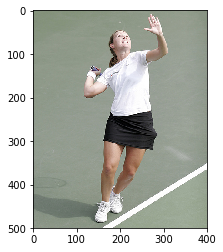

tennis player hits tennis racket with racket


In [51]:
image_nm=test_keys[918]
image = features_vgg[image_nm]
x=plt.imread('../input/flicker8k-dataset/Flickr8k_Dataset/Flicker8k_Dataset/'+image_nm+'.jpg')
plt.imshow(x)
plt.show()
caption=generate_desc(tokenizer, image, 34)
caption=caption.split(' ')
caption=' '.join(caption[1:-1])
print(caption)

In [53]:
import io
import json
tokenizer_json = tokenizer.to_json()
with io.open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

NameError: name 'json' is not defined

In [ ]:
evaluate_model(model, test_captions, test_features, tokenizer, max_length)